## Ce notebook permet de réaliser la détection d'une arme à feu sur une image ( lié à la page 1_Detection_Image.py)

#### Nous utiliserons un algorithme de Deep Learning, appelé CNN ( Convolutionnal Central Neural Networks) pour réaliser la classification des images

In [57]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models


## Charger et préparer les données

https://www.kaggle.com/datasets/syedwajeeh19/weapon-detection-dataset-for-yolov3/data

#### Nous utiliserons un CNN pour la détection des images

#### Le dataset présent à déjà annoté les images, c'est à dire que les coordonnées qui représente les armes à feu sont déjà présentes. Il faut maintenant entrainer le modèle à détecter ( ou non ) une image

In [58]:
# Chemin vers les images
chemin_images = "C:\\Users\\yayou\\Desktop\\detection_arme\\DataSet Info\\images"
categories = [
    {
        "folder_name": "pistol",
        "images": []
    },
    {
        "folder_name": "rifle",
        "images": []
    },
    {
        "folder_name": "knife",
        "images": []
    }
]


In [59]:
def preprocess_image(image_file_path):
    # Charger l'image
    image = tf.keras.preprocessing.image.load_img(image_file_path, target_size=(224, 224))
    # Convertir l'image en tableau numpy
    image = tf.keras.preprocessing.image.img_to_array(image)
    # Normaliser l'image
    image = image / 255.0

    return image

In [60]:
# Ajout des noms de fichiers et des étiquettes dans les listes d'images
for category in categories:
    folder_name = category["folder_name"]
    print("Chargement des images de la catégorie", folder_name)

    for filename in os.listdir(chemin_images + "\\" + folder_name):
        file_path = os.path.join(chemin_images, folder_name, filename)

        if filename.endswith((".jpg", ".jpeg")):
            category["images"].append({
                "filename": filename,
                "image": preprocess_image(file_path),
                "label": folder_name
            })

    print("Chargement des images de la catégorie", folder_name, "terminé")
    print("Nombre d'images chargées :", len(category["images"]))

Chargement des images de la catégorie pistol
Chargement des images de la catégorie pistol terminé
Nombre d'images chargées : 299
Chargement des images de la catégorie rifle
Chargement des images de la catégorie rifle terminé
Nombre d'images chargées : 281
Chargement des images de la catégorie knife
Chargement des images de la catégorie knife terminé
Nombre d'images chargées : 144


In [61]:
categories[0]["images"][0]["image"].shape

(224, 224, 3)

In [62]:
# Séparation en variables d'entraînement et de validation
X = []
y = []

X_valid = []
y_valid = []
X_valid_filename = []

for category in categories:
    images = category["images"]
    for i in range(len(images)):
        if i < 0.8 * len(images): # 80% des images pour l'entraînement
            X.append(images[i]["image"])
            y.append(images[i]["label"])
        else: # 20% des images pour la validation
            X_valid.append(images[i]["image"])
            y_valid.append(images[i]["label"])
            X_valid_filename.append(images[i]["filename"])

X = np.array(X)
y = np.array(y)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

print("X shape :", X.shape)
print("y shape :", y.shape)
print("X_valid shape :", X_valid.shape)
print("y_valid shape :", y_valid.shape)

X shape : (581, 224, 224, 3)
y shape : (581,)
X_valid shape : (143, 224, 224, 3)
y_valid shape : (143,)


In [63]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)
y_valid = label_encoder.transform(y_valid)

Séparation des données en train et test

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Labels encoding

In [65]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [69]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(464, 224, 224, 3)
(464, 3)
(117, 224, 224, 3)
(117, 3)


### Modèle InceptionV3

In [70]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights="imagenet",
                         include_top=False,
                         input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 5s 0us/step


In [71]:
for layers in base_model.layers:
    layers.trainable = False

last_layer = base_model.get_layer("mixed7")
last_output = last_layer.output

In [72]:
from tensorflow.keras.optimizers import RMSprop, Adam
from keras import Model

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(len(categories), activation="softmax")(x)

model_inception = Model(base_model.input,output)

model_inception.compile(optimizer="adam", loss = "categorical_crossentropy",metrics = ["accuracy"])

Training

In [74]:
history_1 = model_inception.fit(
        X_train,y_train,
        epochs=20,
        validation_data=(X_test,y_test))

Epoch 1/20
15/15 [==============================] - 25s 2s/step - loss: 0.0561 - accuracy: 0.9978 - val_loss: 0.3434 - val_accuracy: 0.8803
Epoch 2/20
15/15 [==============================] - 20s 1s/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 0.3394 - val_accuracy: 0.8718
Epoch 3/20
15/15 [==============================] - 20s 1s/step - loss: 0.0227 - accuracy: 0.9978 - val_loss: 0.3146 - val_accuracy: 0.8718
Epoch 4/20
15/15 [==============================] - 19s 1s/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.3061 - val_accuracy: 0.8718
Epoch 5/20
15/15 [==============================] - 26s 2s/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.3069 - val_accuracy: 0.8803
Epoch 6/20
15/15 [==============================] - 25s 2s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 0.8803
Epoch 7/20
15/15 [==============================] - 25s 2s/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.3012 - val_accuracy: 0.8803
Epoch 8/20
15/15 [==

### Évaluation du modèle

Courbes de précision et de perte

C:\Users\yayou\AppData\Local\Temp\ipykernel_23672\4152981858.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


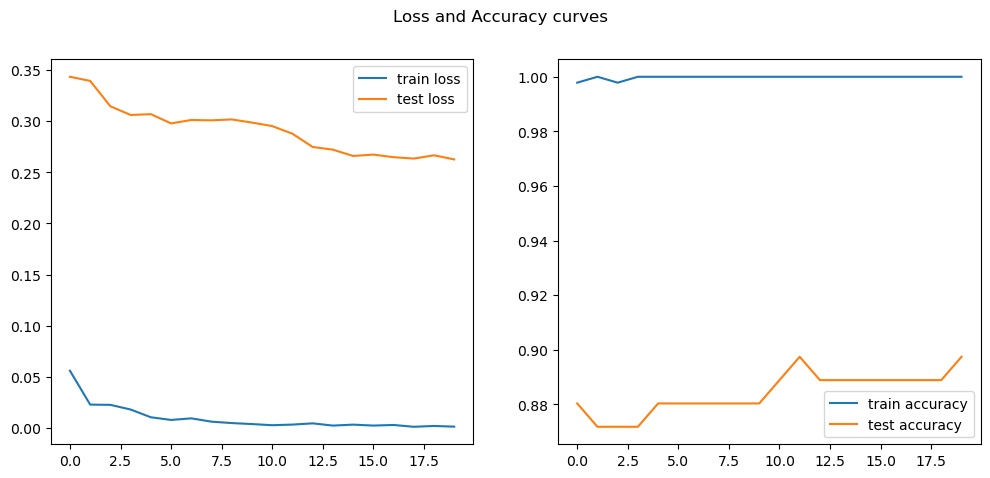

In [75]:
losss = history_1.history['loss']
accu = history_1.history['accuracy']
val_loss = history_1.history['val_loss']
val_accu = history_1.history['val_accuracy']
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Loss and Accuracy curves')
ax1.plot(losss, label='train loss')
ax1.plot(val_loss, label='test loss')
ax1.legend(loc="upper right")
ax2.plot(accu, label='train accuracy')
ax2.plot(val_accu, label='test accuracy')
ax2.legend()
fig.show()

Matrice de confusion

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [80]:
def conf_matrix(m, X, Y):
    predictions = m.predict(X)
    y_pred = []
    for pred in predictions:
        y_pred.append(np.argmax(pred))
    y_pred = np.array(y_pred)
    print('Validation Accuracy : ', accuracy_score(Y, y_pred))
    cm = confusion_matrix(y_pred, Y)
    f,ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(cm)

5/5 [==============================] - 7s 1s/step
Validation Accuracy :  0.9370629370629371


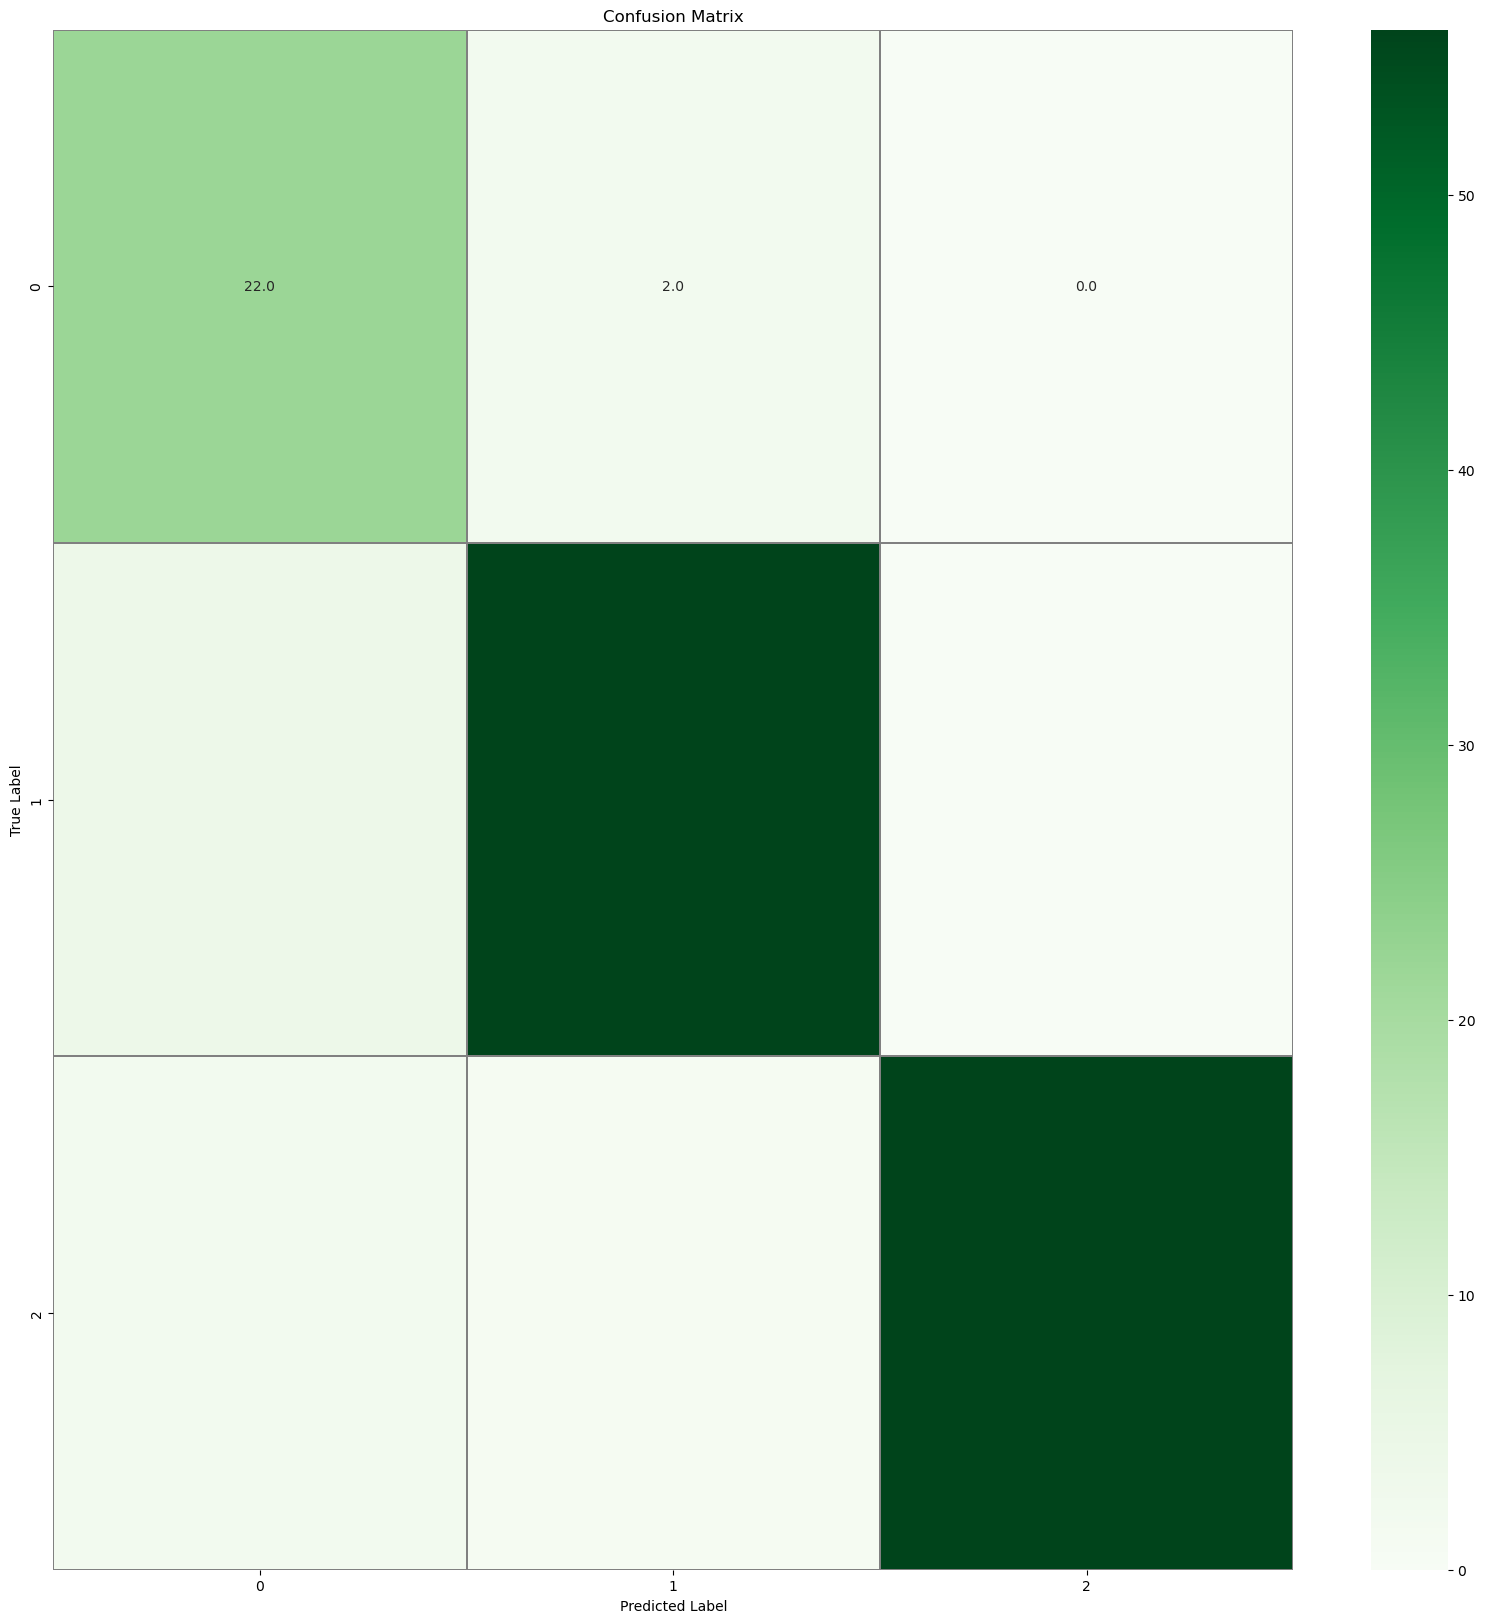

[[22  2  0]
 [ 4 56  0]
 [ 2  1 56]]


In [81]:
conf_matrix(model_inception, X_valid, y_valid)

Sauvegarde du modèle

In [82]:
model_inception.save("model_inception.h5")